# ProcessOptimizer
This notebook will showcase some of the features of ProcessOptimizer by walking though a mathematical benchmark optimization example

## Import the usual suspects and check for software version:


In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np

import ProcessOptimizer as po
from ProcessOptimizer.plots import plot_objective
from ProcessOptimizer.utils import create_result
np.random.seed(42)

In [2]:
po.__version__

'0.6.0'

## Define the problem to be solved
In this case, we will focus on solving a mathematical benchmark. Specifically, the Branin function which is a 2d function (which mean that we can easily plot and understand the results). Furthermore, the Branin function is chosen because it has often been used for this kind of benchmarking. It has three natutal minima and we hope to be able to locate those. Furthermore, to increase the complexity and highlight features of the ProcessOptimizer, we will seek to impose constraints on the optimization and perform multipurpose optimization, so we chose to minimize the actual branin function while also minimizing a made-up cost-function (namely a linear combination of the two input-features):

In [3]:
def branin_2d(x, a=1, b=5.1 / (4 * np.pi**2), c=5. / np.pi,
           r=6, s=10, t=1. / (8 * np.pi)):
    """Branin-Hoo function is defined on the square x1 ∈ [-5, 10], x2 ∈ [0, 15].
    It has three minima with f(x*) = 0.397887 at x* = (-pi, 12.275),
    (+pi, 2.275), and (9.42478, 2.475).
    More details: <http://www.sfu.ca/~ssurjano/branin.html>
    """
    result = (a * (x[1] - b * x[0] ** 2 + c * x[0] - r) ** 2 +
            s * (1 - t) * np.cos(x[0]) + s)
    adduct = (x[0]+6)*15+x[1]
    return result, adduct


Translated to everyday terms: the Branin function could be the unknown function that governs the yield of a chemical reaction (in this case the negative version of the yield, because the algorithm will minimize the target score). x[0] and x[1] are the chemicals used in the reaction. The two chemicals are differently difficult to handle and differently priced, hence one chemical (x[0]) is priced as ([amount]+6)x15 to reflect that the chemist needs to weight off extra and pay a 15 x higher price pr amount as compared to chemical 2 (x[1]). <br>
It therefore stands to reason that we would like to minimize the negative yield while also minimizing the cost of each reaction. <br>
Let's plot the function governing the "yield" of the reaction. We mark the extrema in red:

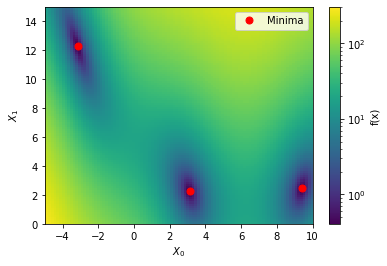

In [4]:
def plot_branin_2d():
    fig, ax = plt.subplots()

    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape([branin_2d(val)[0] for val in vals], (100, 100))
    
    cm = ax.pcolormesh(x_ax, y_ax, fx,shading='auto',
                       norm=LogNorm(vmin=fx.min(), 
                                    vmax=fx.max()))

    minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14, lw=0, label="Minima")
    
    cb = fig.colorbar(cm)
    cb.set_label("f(x)")
    
    ax.legend(loc="best", numpoints=1)
    
    ax.set_xlabel("$X_0$")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("$X_1$")
    ax.set_ylim([0, 15])
    
plot_branin_2d()

Likewise, we can plot the cost function:

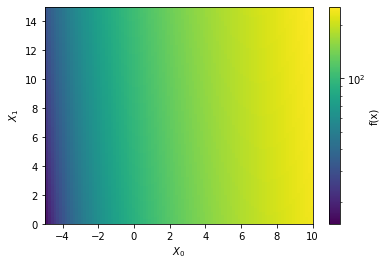

In [5]:
def plot_branin_2d():
    fig, ax = plt.subplots()

    x1_values = np.linspace(-5, 10, 100)
    x2_values = np.linspace(0, 15, 100)
    x_ax, y_ax = np.meshgrid(x1_values, x2_values)
    vals = np.c_[x_ax.ravel(), y_ax.ravel()]
    fx = np.reshape([branin_2d(val)[1] for val in vals], (100, 100))
    
    cm = ax.pcolormesh(x_ax, y_ax, fx,shading='auto',
                       norm=LogNorm(vmin=fx.min(), 
                                    vmax=fx.max()))

    #minima = np.array([[-np.pi, 12.275], [+np.pi, 2.275], [9.42478, 2.475]])
    #ax.plot(minima[:, 0], minima[:, 1], "r.", markersize=14, lw=0, label="Minima")
    
    cb = fig.colorbar(cm)
    cb.set_label("f(x)")
    
    #ax.legend(loc="best", numpoints=1)
    
    ax.set_xlabel("$X_0$")
    ax.set_xlim([-5, 10])
    ax.set_ylabel("$X_1$")
    ax.set_ylim([0, 15])
    
plot_branin_2d()

## Setup the optimizer
We start by defining `space` in which we allow the optimizer to search for best conditions <br>
Then we instantiate the optimizer object: `opt` <br>
For now, we will keep the instantiation simple by taking a "out-of-the-box" gaussian-process regression with 10 initial points (to train model). Those 10 points will be destributed in the space by a latin hyper cube sampling to ensure a broad search. We instantiate a multiobjective optimization by setting `n_objectives=2`

In [6]:
space = [(-5.0,10.0), (0.0,15.0)]
opt = po.Optimizer(space, 
                   base_estimator="GP", 
                   n_initial_points=10, 
                   lhs=True, 
                   n_objectives=2
                  )

We can now ask for new experiments with the ask-method, see:

In [7]:
opt.ask()

[3.25, 0.75]

## Initiate experimentation
Let's make 15 initial experiments. 10 of these will be base on Latin hyper cube, the rest will be governed by the multiobjective optimization

In [8]:
total_iterations = 0
for i in range(15):
    new_point=opt.ask()
    obj1=branin_2d(new_point)[0]
    obj2=branin_2d(new_point)[1]
    obj=[obj1,obj2]
    opt.tell(new_point,obj)
    total_iterations += 1

We can plot the experiments. First we focus only on the position in the x-space ("where did we search for optimal conditions"):

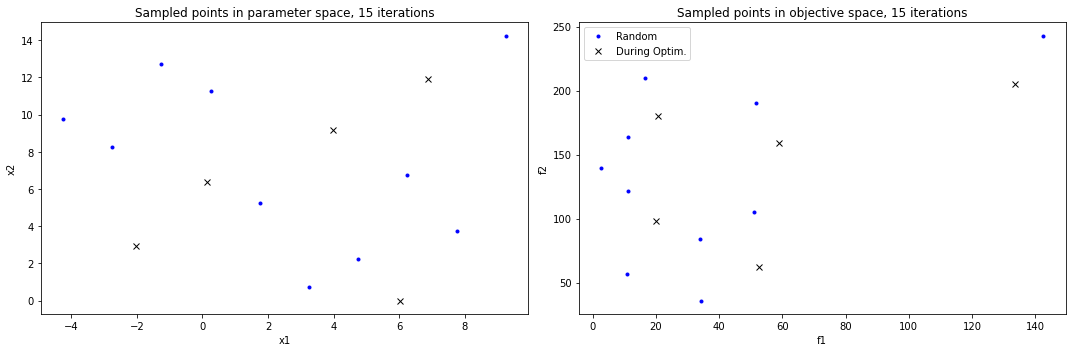

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(np.array(opt.Xi)[0:10,0],np.array(opt.Xi)[0:10,1], 'b.')
axs[0].plot(np.array(opt.Xi)[10:,0],np.array(opt.Xi)[10:,1], 'kx')
axs[0].set_title('Sampled points in parameter space, '+str(total_iterations) + ' iterations')
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')

axs[1].plot(np.array(opt.yi)[0:10,0],np.array(opt.yi)[0:10,1], 'b.', label = 'Random')
axs[1].plot(np.array(opt.yi)[10:,0],np.array(opt.yi)[10:,1], 'kx', label = 'During Optim.')
axs[1].set_title('Sampled points in objective space, '+str(total_iterations) + ' iterations')
axs[1].set_xlabel('f1')
axs[1].set_ylabel('f2')
axs[1].legend(loc='best')


fig.tight_layout()
plt.show()

We can also plot the present model for the pareto from. A pareto front is the expected results (based on the current best model) that cannot be dominated by better experiments. i.e. the points where one output parameter can only be improved at the cost of the other output parameter - as in the case where the yield can only improve by realising a higher price.

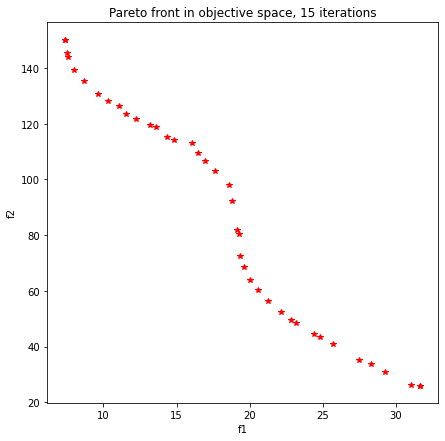

In [10]:
pop, logbook, front = opt.NSGAII()

fig = plt.figure(figsize=(7,7))
plt.plot(front[:,0],front[:,1], 'r*')
plt.title('Pareto front in objective space, ' + str(total_iterations) + ' iterations')
plt.xlabel('f1')
plt.ylabel('f2')

plt.show()

Finally, let's plot the current best model for the objective functions. First, we plot the first objective (the "yield"). <br>
As we are working with multiple objective functions and hence multiple internals models, we need to extract the results for the wanted objective, in this case the first (zero index):

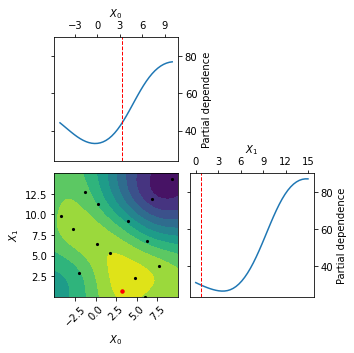

In [11]:
result_yield = create_result(Xi=opt.Xi, 
                             yi=[i[0] for i in opt.yi], 
                             space=opt.space, 
                             models=[i[0] for i in opt.models])
plot_objective(result_yield);

And we plot the current best model for the cost function:

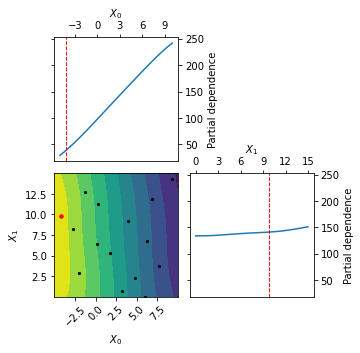

In [12]:
result_price = create_result(Xi=opt.Xi, 
                             yi=[i[1] for i in opt.yi], 
                             space=opt.space, 
                             models=[i[1] for i in opt.models])
plot_objective(result_price);

## Continue experimentation
Let's add an additional 15 experiments

In [13]:
for i in range(15):
    new_point=opt.ask()
    obj1=branin_2d(new_point)[0]
    obj2=branin_2d(new_point)[1]
    obj=[obj1,obj2]
    opt.tell(new_point,obj)
    total_iterations += 1

And plot in the feature space:

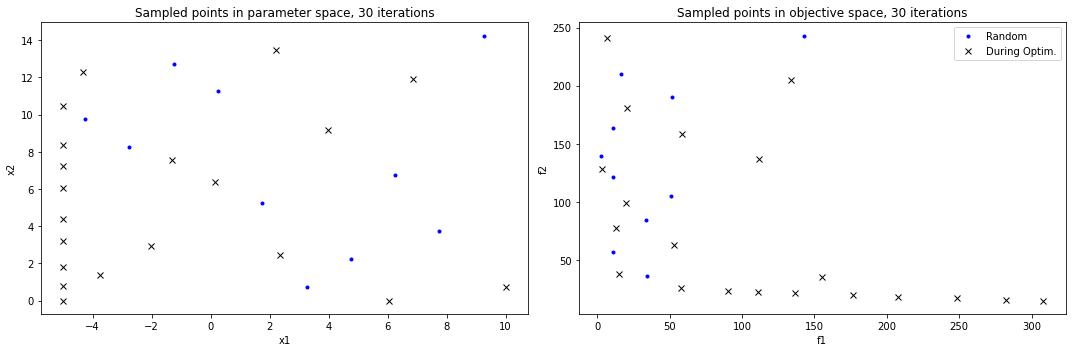

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

axs[0].plot(np.array(opt.Xi)[0:10,0],np.array(opt.Xi)[0:10,1], 'b.')
axs[0].plot(np.array(opt.Xi)[10:,0],np.array(opt.Xi)[10:,1], 'kx')
axs[0].set_title('Sampled points in parameter space, '+str(total_iterations) + ' iterations')
axs[0].set_xlabel('x1')
axs[0].set_ylabel('x2')

axs[1].plot(np.array(opt.yi)[0:10,0],np.array(opt.yi)[0:10,1], 'b.', label = 'Random')
axs[1].plot(np.array(opt.yi)[10:,0],np.array(opt.yi)[10:,1], 'kx', label = 'During Optim.')
axs[1].set_title('Sampled points in objective space, '+str(total_iterations) + ' iterations')
axs[1].set_xlabel('f1')
axs[1].set_ylabel('f2')
axs[1].legend(loc='best')

fig.tight_layout()
plt.show()

...And now we can plot the calculated and realized Pareto front again. In the following plot, the red stars are the calculated Pareto-front. Blue dot's are the training data (10 points) and the black points are the points investigated during the optimization

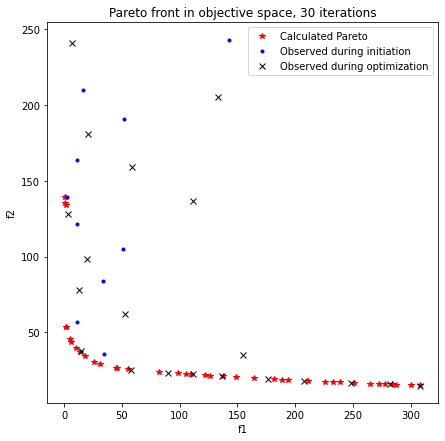

In [15]:
pop, logbook, front = opt.NSGAII()

fig = plt.figure(figsize=(7,7))
plt.plot(front[:,0],front[:,1], 'r*', label='Calculated Pareto')
plt.title('Pareto front in objective space, ' + str(total_iterations) + ' iterations')
plt.xlabel('f1')
plt.ylabel('f2')
plt.plot([i[0] for i in opt.yi[:10]],[i[1] for i in opt.yi[:10]], 'b.', label='Observed during initiation')
plt.plot([i[0] for i in opt.yi[10:]],[i[1] for i in opt.yi[10:]], 'kx', label='Observed during optimization')
plt.legend(loc='best')

plt.show()

Let's look at some of the options for plotting <br>
plot_objective will, given a `result`, plot the best model for the unknown function. A number of additional keywords can be passed:
* `levels`: 
 * Can either simply represent the "resolution" of the picture (how many nuances of colors are shown from the underlaying colormap). use: `levels=10`
 * Can also be given as a complex type to indicate the overall min (0) and max (300) and number of levels (35) of the colored 2d plot(s): `levels = np.linspace(0, 300, 35)`. **This is the setting to use, if you want all 2d plots to share the same scale of the z-axis**
* `n_points`:
 * Number of points at which to evaluate the partial dependence along each dimension.
* `n_samples`:
 * Number of random samples to use for averaging the model function at each of the `n_points`
* `size`:
 * Height (in inches) of each facet.
* `zscale`:
 * Scale to use for the z axis of the contour plots. Either `linear` or `log`. Defaults to linear
* `dimensions`:
 * A list of names for the dimensions
* `usepartialdependence`:
 * Whether to use partial dependence or not when calculating dependence. If `False` plot_objective will parse values to the dependence function, defined by the pars argument. If `True` the average effect of all other variables are being used in the plot. I.e. partial dependence show an averaged look, while Non-partial dependence will show the "landscape" seen from a specific point.
* `pars`:
 * Defines the values for the red points in the plots, and if partialdependence is `False`, this argument also defines values for all other parameters when calculating dependence. Valid strings:  
  1. `result` - Use best observed parameters
  2. `expected_minimum` - Parameters that gives the best minimum calculated using scipy's minimize method. This method currently does not work with categorical values.
  3. `expected_minimum_random` - Parameters that gives the best minimum when using naive random sampling. Works with categorical values
* `expected_minimum_samples` Determines how many points should be evaluated to find the minimum when using 'expected_minimum' or 'expected_minimum_random'

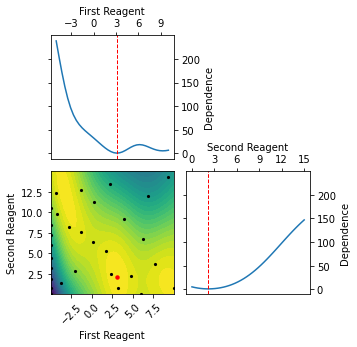

In [16]:
result_yield = create_result(Xi=opt.Xi, 
                             yi=[i[0] for i in opt.yi], 
                             space=opt.space, 
                             models=[i[0] for i in opt.models])
plot_objective(result_yield, 
               levels = np.linspace(0, 300, 35),
               n_points = 40,
               n_samples = 250,
               size = 2,
               zscale = 'linear',
               dimensions = ['First Reagent', 'Second Reagent'],
               usepartialdependence = False,
               pars = 'expected_minimum',
               expected_minimum_samples = 5
              );

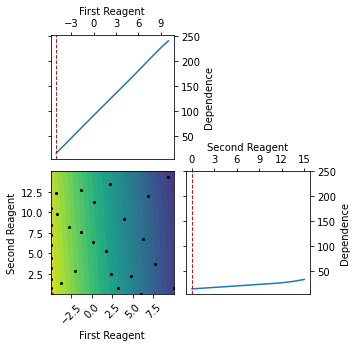

In [17]:
result_price = create_result(Xi=opt.Xi, 
                             yi=[i[1] for i in opt.yi], 
                             space=opt.space, 
                             models=[i[1] for i in opt.models])
plot_objective(result_price,
               levels = np.linspace(0, 300, 35),
               n_points = 40,
               n_samples = 250,
               size = 2,
               zscale = 'linear',
               dimensions = ['First Reagent', 'Second Reagent'],
               usepartialdependence = False,
               pars = 'expected_minimum',
               expected_minimum_samples = 5
              );

## Conclusion
We would now be able to inform decision-makers with a model of the trade-off between yield and cost for this "chemical reaction". This would be displayed with the Pareto front. Furthermore, we have predictive models for both objectives.

## Bonus
If you want to make a colorbar corresponding to the ranges chosen for the 2d prints, you can do something like this:

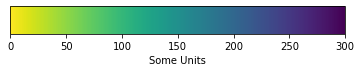

In [18]:
import matplotlib.pyplot as plt
import matplotlib as mpl

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)

cmap = mpl.cm.viridis_r
norm = mpl.colors.Normalize(vmin=0, vmax=300)

cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Some Units')